Implement greedy algorithm for submod. fn. Max. (IC):
 * For budget = 1 to n_documents
   * Simulate process k times for every new candidate, and pick candidate which, on average (i.e. in expectation), when added to the seed set maximizes the spread caused by the seed set

Request these votes, and aggregate in a fixed way (e.g. MV or MVNN).


In [1]:
%load_ext autoreload

In [2]:
import os
import sys

print("Current Python: {0}".format(sys.executable))

# This makes Jupyter pretend to be Pythonic and play well with modules.
sys.path.append(os.path.expandvars(os.path.join(os.getcwd(), '..')))

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from collections import OrderedDict
import datetime
import io
import os
import random

%matplotlib inline

Current Python: /Users/andrei/anaconda3/envs/crowd/bin/python


In [3]:
%autoreload 2

from crowd.data import *
from crowd.config import *
from crowd.file_util import *
from crowd.graph import *
from crowd.topic import *
from crowd.simulation import *

In [4]:
SIM_THRESHOLD = 0.75

id_topic_info = load_topic_metadata()
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)
test_data = read_all_test_labels()

# Pick one single topic to mess around with at the moment.
# Topic: 20814 Elvish Language
topic_id = '20814'
graph = build_nx_document_graph(
    id_topic_info[topic_id],
    test_data,
    get_topic_judgements_by_doc_id(topic_id, judgements),
    FULLTEXT_FOLDER,
    sim_threshold=SIM_THRESHOLD,
    discard_empty=False)
topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
topic_ground_truth = {truth.document_id: truth for truth in test_data
                          if truth.topic_id == topic_id}

print("Not discarding empty nodes")
print("Nodes: {}".format(graph.nx_graph.number_of_nodes()))
print("Edges: {}".format(graph.nx_graph.number_of_edges()))

graph_disc = build_nx_document_graph(
    id_topic_info[topic_id],
    test_data,
    get_topic_judgements_by_doc_id(topic_id, judgements),
    FULLTEXT_FOLDER,
    sim_threshold=SIM_THRESHOLD,
    discard_empty=True)

print("Discarding empty nodes")
print("Nodes: {}".format(graph_disc.nx_graph.number_of_nodes()))
print("Edges: {}".format(graph_disc.nx_graph.number_of_edges()))

graph = graph_disc

Building nx doc graph
7 relevant documents
3 non-relevant documents
100 documents with votes
0 hidden nodes (due to no data)
Not discarding empty nodes
Nodes: 166
Edges: 334
Building nx doc graph
7 relevant documents
3 non-relevant documents
100 documents with votes
66 hidden nodes (due to no data)
Discarding empty nodes
Nodes: 100
Edges: 62


Connected components: 68
Cliques:              70


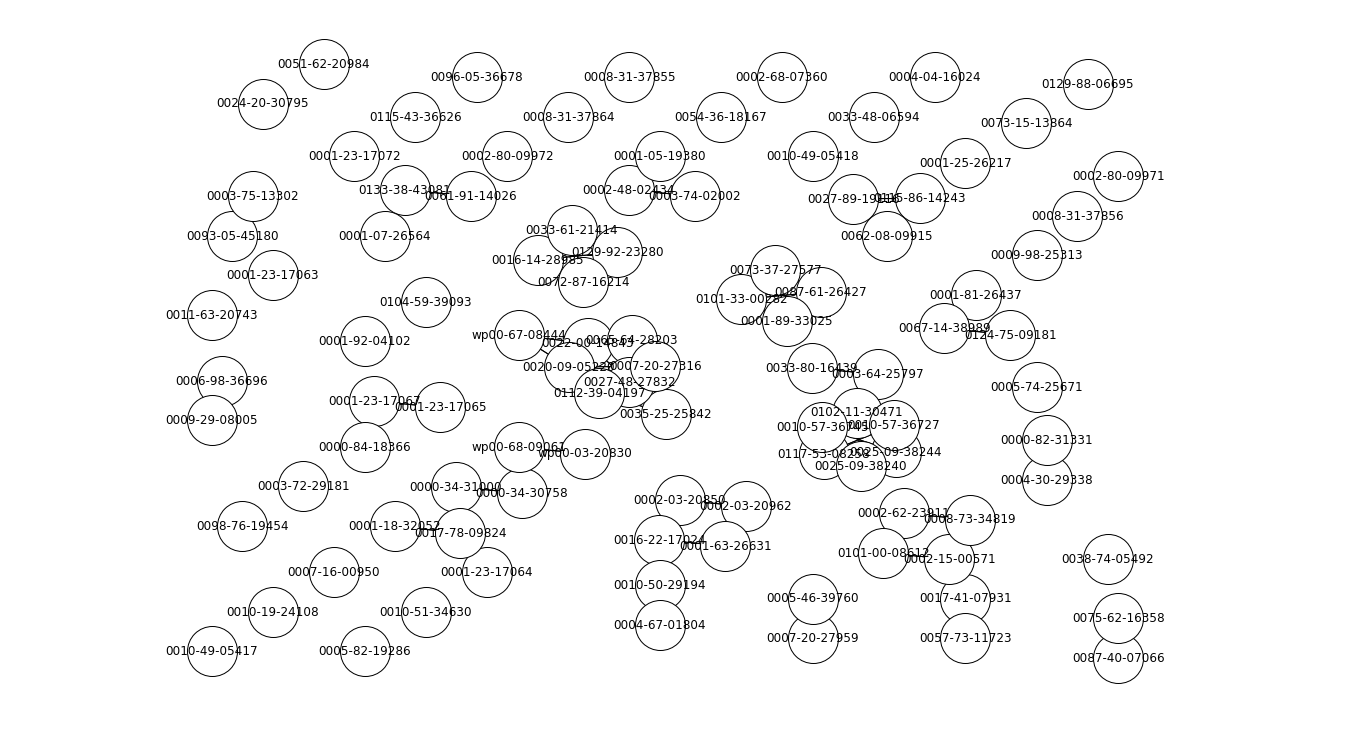

In [5]:
# This is just a sanity check preview. It's not nearly
# as useful as the one in the dedicated similarity graph
# visualization notebook.
# TODO(andrei): Consider always working with NetworkX graphs directly, if it makes sense.

plt.rcParams['figure.figsize'] = (18, 10)

from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(graph.nx_graph)
nx.draw(graph.nx_graph, pos, node_size=2500, node_color='w')
_ = nx.draw_networkx_labels(graph.nx_graph, pos)
# _ = nx.draw_networkx_edge_labels(graph.nx_graph, pos)
nx.draw_networkx_edges(graph.nx_graph, pos)

print("Connected components: {}".format(nx.number_connected_components(graph.nx_graph)))
print("Cliques:              {}".format(nx.graph_number_of_cliques(graph.nx_graph)))

# nx.draw(graph.nx_graph)

In [6]:
ng = graph.nx_graph
n_docs = ng.number_of_nodes()

## TODO list
 * Simulate one iteration of influence maximization under IC.
 * Create function which repeats simulation k several times, and computes the expected influence of a given seed set.
 * Create function which, given a seed set, finds the best addition to that seed set using the above function.
 * Create function which, given a graph and a budget b, computes the approximately best solution to maximize influence.
     * These will be the votes we will request.
 * Plot learning curves for this system, e.g. from budget = 1, up to budget = n_docs, or even n_docs * nr_votes_per doc.
 * Problem: What to do once we reach 100% coverage, i.e. 1 vote for every document?
     * We encounter a similar problem to GP aggregation, cyclicity. Namely, influence spread is maximized when we have sampled every node exactly once, but this doesn't mean that we should be 100% confident our predictions are correct.
     * We need a smart way to model uncertainty beyond 1 vote per doc.
     * Possible solution: Remodel influence maximization problem so that every node spreads information based on its own confidence. If there is consent among voters so far, then its weight is higher than if there is dissent.
 * This technique is VERY CPU-intensive, but also embarrassingly parallel, so we should parallelize it.
 * Write script for one-command deployment to Euler (hint: use Fabric).
 * Model IC/LT configs in a neat OO fashion.
 * Consider estimating the number of tries necessary if using a brute-force approach. For instance, for $n = 150$ documents and a budget $k = b = 15$ we would have to check about $10^{20}$ possible subsets. And this doesn't even count possible uncertainties and needing >1 vote per document to be confident in its relevance. We need submodularity! The **k-max cover problem** is NP-hard.

In [7]:
# TODO(andrei): Be very rigorous with RNG.
import random

def sample_edges(graph, seed_set):
    # Samples every edge in the graph with the probability = similarity.
    # Return the set of reachable nodes given the seed set and the edges we sampled.
    
    sampled = nx.Graph(graph)
    sampled.remove_edges_from(sampled.edges())
#     print("Number of edges: {}".format(sampled.number_of_edges()))
#     print("Size of seed set: {}".format(len(seed_set)))
    
    for from_node, to_node, data in graph.edges(data=True):
        if random.random() <= data['similarity']:
            sampled.add_edge(from_node, to_node)
    
    all_reached = set()
    for seed_node in seed_set:
        reached = set(nx.shortest_path(sampled, source=seed_node).keys())
        all_reached |= reached
        
    return all_reached


def simulate_spread(graph, seed_set, iteration_count):
    """Simulates information spread in 'graph' using IC model.
    
    Returns:
        The influence spread of the given seed set in the graph.
        This is a number beween 0 and the size of the graph signifying
        the number of nodes we expect to reach from the seed set in the
        given graph, approximated using 'iteration_count' iterations.
    """
    reach_sum = 0
    
    for k in range(iteration_count):
        result = sample_edges(graph, seed_set)
        reach_sum += len(result)
        
    reach_exp = reach_sum / iteration_count
    return reach_exp


# TODO(andrei): Use this to test lazy greedy implementation. Should be quite easy.
def pick_next_best(graph, current_seed_set, iteration_count):
    """Picks the node which best improves the information spread of the seed set.
    
    This is a greedy approach, which works because the influence spread function
    is submodular.
    """
    
    best_spread = -1
    best_node = None
    for node in graph.nodes():
        if node not in current_seed_set:
            expected_spread = simulate_spread(
                graph,
                # TODO(andrei): Is there a better way to do this?
                current_seed_set | { node },
                iteration_count)
            
            if expected_spread > best_spread:
                best_spread = expected_spread
                best_node = node
                
    assert best_node is not None, "Must select a node to add to the seed set."
    return best_node, best_spread


import heapq

def compute_best_heap(graph, current_seed_set, iteration_count):
    """Similar to 'pick_next_best', but returns a priority queue of all candidates."""
    
    spread_node_heap = []
    
    for node in graph.nodes():
        if node not in current_seed_set:
            expected_spread = simulate_spread(
                graph,
                current_seed_set | { node },
                iteration_count)
            heapq.heappush(spread_node_heap, (expected_spread, node))
            
    assert len(spread_node_heap) > 0, "Must find at least one candidate node."
    return spread_node_heap


def pick_next_best_lazy(graph, current_seed_set, iteration_count, previous_best_heap):
    # look at top of list (should be sorted); (consider building it as a heap from the
    # beginning);
    
    # recompute value for node on top of list. 
    # if still larger than second, pop and return.
    # else recompute list.
    
    # TODO(andrei): Compute perf metrics and keep track of lazy "hits".
    
    
    
    pass


def build_seed_set(graph, budget, iteration_count):
    seed_set = set()
    for index in range(budget):
        # TODO(andrei): Consider detecting when spread stops improving and quitting early. Does it ever happen?
        best_node, best_spread = pick_next_best(graph, seed_set, iteration_count)
        print("Budget: {}/{}, Spread: {:.2f}".format(index + 1, budget, best_spread))
        seed_set.add(best_node)
        
    return seed_set

# General benchmarks
#
#  * Very first timing,     b = 10, it = 10: 77639828 function calls in 26.211 seconds
#  * Pre-cached node hash,  b = 10, it = 10: 49998191 function calls in 20.735 seconds
#

%prun result = build_seed_set(graph.nx_graph, 10, 10)
clean_res = []
for r in result:
    d_id = r.document_id
    d_id = d_id[d_id.find('-') + 1:]
    d_id = d_id[d_id.find('-') + 1:]
    clean_res.append(d_id)
    
print(sorted(clean_res))
    

Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 14.00
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 22.00
Budget: 5/10, Spread: 24.90
Budget: 6/10, Spread: 27.00
Budget: 7/10, Spread: 28.90
Budget: 8/10, Spread: 30.90
Budget: 9/10, Spread: 32.90
Budget: 10/10, Spread: 34.90
 ['00-08612', '00-14843', '08-09915', '14-28985', '33-00282', '34-30758', '53-08258', '62-23911', '63-26631', '64-25797']


## Sampling + vote aggregation

In [ ]:
def aggregate_MV(topic_graph, all_sampled_votes, **kw):
    # TODO(andrei): This is duplicate code. Please remove.
    return {document_id: majority(document_votes)
            for (document_id, document_votes) in all_sampled_votes.items()}

COIN_FLIP='COIN_FLIP'
def majority(votes, tie_handling=COIN_FLIP):
     # TODO(andrei): This is also duplicate code!
    relevant = len([vote for vote in votes if vote.is_relevant == True])
    non_relevant = len([vote for vote in votes if vote.is_relevant == False])
    
    if relevant > non_relevant:
         return True
    elif relevant < non_relevant:
         return False
    elif tie_handling == COIN_FLIP:
        return random.choice([True, False])
    else:
        raise ValueError("Unknown tie handling technique: [{}]."
                         .format(tie_handling))

class GraphSpreadSampler(DocumentSampler):
    """Tries to sample nodes which maximize information spread.
    
    Uses a greedy approach as the objective function we are trying
    to maximize under the information diffusion model is submodular.
    
    Note: When parallelizing computations, make sure that each worker
    gets its own sampler, as they are stateful. Failure to do so leads
    to race conditions.
    """
    
    def __init__(self, topic_graph, **kw):
        self.topic_graph = topic_graph
        self.seed_set = set()
        self.iteration_count = kw.get('iteration_count', 5)

    def sample(self, existing_votes):
        best_node, best_spread = pick_next_best(
            self.topic_graph.nx_graph,
            self.seed_set,
            self.iteration_count)
        self.seed_set.add(best_node)
        return best_node.document_id
        

class LazyGreedyGraphSpreadSampler(DocumentSampler):
    """Same as 'GraphSpreadSampler' but in a lazy greedy fashion.
    
    Please see [citation pending] for more details.
    """
    
    # TODO(andrei): Implement after testing fn individually.
    pass

        

accuracies = evaluate_iteration(
    graph,
    topic_judgements,
    topic_ground_truth,
    GraphSpreadSampler(graph, iteration_count=5),
    aggregate_MV,
    budget=len(topic_ground_truth.keys()))

In [ ]:
plt.plot(range(len(accuracies)), accuracies)

In [ ]:
# TODO(andrei): Improve modularization, and use more specific name for 'evaluate' 'iterations' arg.

def gss_factory():
    """Ensures that each worker in 'evaluate' has its own copy of the sampler (which is stateful!)."""
    return GraphSpreadSampler(graph, iteration_count=10)

jesus = evaluate(
    graph,
    topic_judgements,
    topic_ground_truth,
    gss_factory,
    aggregate_MV,
    budget=len(topic_ground_truth.keys()),
    iterations=25)

In [ ]:
satan = evaluate(
    graph,
    topic_judgements,
    topic_ground_truth,
    LeastVotesSampler(),
    aggregate_MV,
    budget=len(topic_ground_truth.keys()),
    iterations=25)

In [ ]:
probably_garbage = np.mean(jesus, axis=0)        
satan_avg = np.mean(satan, axis=0)
plt.plot(range(len(probably_garbage)), probably_garbage, label="MV and info spread sampling")
plt.plot(range(len(satan_avg)), satan_avg, label="MV and least-votes")
plt.legend(loc=3)

Old plot: 
    ![title](../oldplot.png)

In [ ]:
def profile_me_like_one_of_your_french_functions():
    for i in range(2):
        x = range(1000)
        y = range(10000)
        z = np.array(range(1000000)).reshape((-1, 1000))
    
    print(z.shape)
    return 3

# TODO(andrei): Use this magic to profile yer code.
%prun profile_me_like_one_of_your_french_functions()

## Result Log

First algorithm testing. SIM_THRESHOLD = 0.75, topic = '20814'

* B = 10, it = 1

```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 14.00
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 22.00
Budget: 5/10, Spread: 25.00
Budget: 6/10, Spread: 27.00
Budget: 7/10, Spread: 29.00
Budget: 8/10, Spread: 31.00
Budget: 9/10, Spread: 33.00
Budget: 10/10, Spread: 35.00
['11-30471', '15-00571', '22-17024', '23-17065', '34-30758', '61-26427', '62-23911', '67-08444', '87-16214', '89-19116']
```

* B = 10, it = 5
 
```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 14.00
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 22.00
Budget: 5/10, Spread: 25.00
Budget: 6/10, Spread: 27.00
Budget: 7/10, Spread: 29.00
Budget: 8/10, Spread: 31.00
Budget: 9/10, Spread: 33.00
Budget: 10/10, Spread: 35.00
['03-20962', '15-00571', '18-32052', '22-17024', '23-17065', '57-36745', '61-26427', '67-08444', '87-16214', '89-19116']
```
 
 * B = 10, it = 10:
 
```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 14.00
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 22.00
Budget: 5/10, Spread: 24.80
Budget: 6/10, Spread: 27.00
Budget: 7/10, Spread: 29.00
Budget: 8/10, Spread: 31.00
Budget: 9/10, Spread: 32.90
Budget: 10/10, Spread: 35.00
['08-09915', '09-38244', '22-17024', '23-17067', '34-30758', '61-26427', '67-08444', '78-09824', '87-16214', '91-14026']

```

 * B = 10, it = 50
 
```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 13.98
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 21.98
Budget: 5/10, Spread: 24.92
Budget: 6/10, Spread: 26.90
Budget: 7/10, Spread: 28.84
Budget: 8/10, Spread: 30.94
Budget: 9/10, Spread: 32.90
Budget: 10/10, Spread: 34.80
['11-30471', '25-25842', '34-30758', '61-21414', '63-26631', '74-02002', '78-09824', '80-16439', '89-19116', '89-33025']
```

 * B = 10, it = 150
```
Budget: 1/10, Spread: 7.97
Budget: 2/10, Spread: 13.98
Budget: 3/10, Spread: 17.96
Budget: 4/10, Spread: 21.97
Budget: 5/10, Spread: 24.90
Budget: 6/10, Spread: 26.86
Budget: 7/10, Spread: 28.89
Budget: 8/10, Spread: 30.89
Budget: 9/10, Spread: 32.83
Budget: 10/10, Spread: 34.85
['09-38244', '18-32052', '22-17024', '34-30758', '48-27832', '61-26427', '64-25797', '74-02002', '87-16214', '89-19116']
```